<a href="https://colab.research.google.com/github/ShawnLiu119/Time-Series-SalesProj-ARIMA/blob/main/Sales_Projection_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/ShawnLiu119/Time-Series-SalesProj-ARIMA.git

Cloning into 'Time-Series-SalesProj-ARIMA'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [9]:
!cd /content/Time-Series-SalesProj-ARIMA

In [35]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [36]:
#load the dataset

df = pd.read_csv('/content/Time-Series-SalesProj-ARIMA/Dataset- Superstore (2015-2018).csv')

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016/11/08,2016/11/11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016/11/08,2016/11/11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016/06/12,2016/06/16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015/10/11,2015/10/18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015/10/11,2015/10/18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [37]:
#data exploration

df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [38]:
## we will focus on forecast office supply category

df_os = df[df['Category'] == 'Office Supplies']

print('starting date is {}'.format(df_os['Order Date'].min()))
print('ending date is {}'.format(df_os['Order Date'].max()))
#There are 4 years data

starting date is 2014/01/03
ending date is 2017/12/30


####Data Preprocessing

removing unrelevant variables, handling missing data, aggregate sales by date. 
skip only two columns:Oder Date and Sales

In [41]:
df_os = df_os[['Order Date','Sales']]
df_os.head()

,Order Date,Sales
2,2016/06/12,14.620
4,2015/10/11,22.368
6,2014/06/09,7.280
8,2014/06/09,18.504
9,2014/06/09,114.900


In [42]:
## missing value
df_os.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [59]:
df_os_date = df_os.groupby(['Order Date']).sum().reset_index()
df_os_date.shape

(1148, 2)

In [60]:
df_os_date['Order Date'] = pd.to_datetime(df_os_date['Order Date'])  #need to convert 'str' index to 'datetime'index required by resample() -->timeseries practise
df_os_date = df_os_date.set_index(['Order Date'])

#### EDA

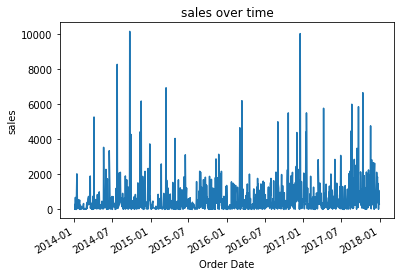

In [61]:
df_os_date['Sales'].plot()
plt.xlabel('Order Date')
plt.ylabel('sales')
plt.title('sales over time')
plt.show()

In [66]:
## can use monthly average sales to simplify the graph and see the pattern
#Convenience method for frequency conversion and resampling of time series. The object must have a datetime-like index (DatetimeIndex, PeriodIndex, or TimedeltaIndex), or the caller must pass the label of a datetime-like series/index to the on/level keyword parameter.

# # resampling MS:
# date.resample('MS').mean()

# 2022-01-01    0.5
# 2022-02-01    2.0
# Freq: MS, dtype: float64

# # resampling M:
# date.resample('M').mean()
# 2022-01-31    0.5
# 2022-02-28    2.0
# Freq: M, dtype: float64


df_mon_os = pd.DataFrame()

df_mon_os['Sales'] = df_os_date['Sales'].resample('MS').mean()
df_mon_os.head()

,Sales
Order Date,
2014-01-01,285.357647
2014-02-01,63.042588
2014-03-01,391.176318
2014-04-01,464.794750
2014-05-01,324.346545


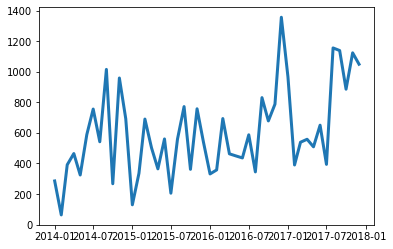

In [67]:
plt.plot(df_mon_os.index, df_mon_os['Sales'], linewidth=3 )

In [68]:
# We can nicely visualize the trend and how it varies each year in a nice year-wise boxplot.
# Likewise, we can do a month-wise boxplot to visualize the monthly distributions.
# Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

df_os_date['year'] = [d.year for d in df_os_date.index]
df_os_date['date'] = [d.month for d in df_os_date.index]

df_os_date.head()

,Sales,year,date
Order Date,,,
2014-01-03,16.448,2014,1
2014-01-04,288.060,2014,1
2014-01-05,19.536,2014,1
2014-01-06,685.340,2014,1
2014-01-07,10.430,2014,1
